In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
import seaborn as sns
from scipy import linalg as LA

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(789)

In [2]:
# import data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
train_data, train_label, test_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


(55000, 784)
0.0 1.0
(55000, 10)
0.0 1.0
(10000, 784)
0.0 1.0
(10000, 10)
0.0 1.0
-----------------------


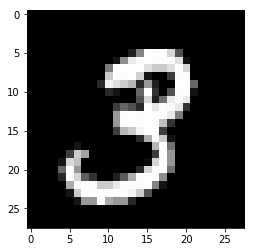

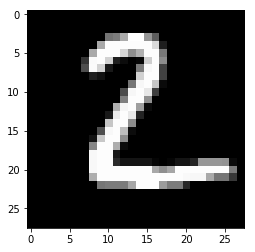

In [3]:
# Show some details and vis some of them
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_label.shape)
print(train_label.min(),train_label.max())
print(test_data.shape)
print(test_data.min(),test_data.max())
print(test_label.shape)
print(test_label.min(),test_label.max())
print('-----------------------')

plt.imshow(train_data[1].reshape((28,28)),cmap='gray')
plt.show()
plt.imshow(test_data[1].reshape((28,28)),cmap='gray')
plt.show()

In [4]:
# create layer
def np_sigmoid(x): return 1.0 / (1.0+np.exp(-x))
def d_np_sigmoid(x): return np_sigmoid(x) * (1.0 - np_sigmoid(x))

# fully connected layer
class np_FNN():
    
    def __init__(self,inc,outc):
        self.w = np.random.randn(inc,outc)
        self.m,self.v = np.zeros_like(self.w),np.zeros_like(self.w)
        
    def feedforward(self,input):
        self.input  = input
        self.layer  = self.input.dot(self.w)
        self.layerA = np_sigmoid(self.layer)
        return serf.layerA
    
    def backprop(self,grad):
        grad_1 = grad
        grad_2 = d_np_sigmoid(self.layer)
        grad_3 = self.input
        
        grad_middle = grad_1 * grad_2
        grad = grad_3.T.dot(grad_middle) / batch_size
        grad_pass = grad_middle.dot(self.w.T)
        
        self.m = self.m * beta1 + (1. - beta1) * grad 
        self.v = self.v * beta2 + (1. - beta2) * grad ** 2
        m_hat,v_hat = self.m/(1.-beta1), self.v/(1.-beta2)
        adam_middle = learning_rate / (np.sqrt(v_hat) + adam_e) * m_hat
        self.w = self.w - adam_middle
        
        return grad_pass

# def: centering layer
class centering_layer():
    
    def __init__(self,batch_size):
        self.m = batch_size
        
    def feedforward(self,x):
        x_mean = np.sum(x,axis=0)
        return x - (1./self.m) * x_mean
    
    def backprop(self,grad):
        return grad * ( 1. - 1./self.m )
    
# def: whiten layer without centering
class zca_whiten_layer():
    
    def __init__(self,batch_size,feature_size):
        self.m = batch_size
        self.n = feature_size
        self.moving_sigma = 0
        self.moving_mean = 0
        
    def feedforward(self,input,EPS=1e-10):
        self.input = input
        self.sigma = input.T.dot(input) / input.shape[0]
        self.eigenval,self.eigvector = LA.eigh(self.sigma)
        self.U = self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS))).dot(self.eigvector.T)
        self.whiten = input.dot(self.U)
        return self.whiten
    
    def backprop(self,grad,EPS=1e-10):
        d_eig_vector = self.whiten.T.dot(grad) + \
                       self.input.T.dot(grad.dot(self.eigvector.T)).dot(np.diag(1. / np.sqrt(self.eigenval+EPS)).T)
        
        d_eig_value  = self.input.T.dot(grad.dot(self.eigvector.T)) \
                     * (-1/2) * np.diag(1. / (self.eigenval+EPS) ** 1.5 )
        
        E = np.ones((self.n,1)).dot(np.expand_dims(self.eigenval.T,0)) - \
                   np.expand_dims(self.eigenval,1).dot(np.ones((1,self.n)))
        K_matrix = 1./(E + np.eye(self.n)) - np.eye(self.n)
        d_sigma = self.eigvector.dot(
                    K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + \
                    d_eig_value
                    ).dot(self.eigvector.T)
        
        d_simg_sym = (0.5) * (d_sigma.T + d_sigma)
        d_x = grad.dot(self.eigvector.T).dot(self.U.T) + \
              (2./self.m) * self.input.dot(d_simg_sym.T)
        return d_x
    
# check if layer is correct
# https://gist.github.com/dmaniry/5170087 there are some minor differences
def zca_whiten(X):
    EPS = 1e-10
    sigma = np.dot(X.T,X) / X.shape[0]
    U, S, V = np.linalg.svd(sigma)
    tmp = np.dot(U, np.diag(1/np.sqrt(S+EPS)))
    W = np.dot(tmp, U.T)
    Xwhite = X.dot(W.T)
    return Xwhite    
    
# def: Decorrelated Batch Normalization 
class Decorrelated_Batch_Norm():
    
    def __init__(self,batch_size,feature_size):
        self.m = batch_size
        self.n = feature_size

    def feedforward(self,input,EPS=1e-5):
        self.input = input
        self.mean = (1./self.m) * np.sum(input,axis=0)
        self.sigma = (1./self.m) * (input - self.mean).T.dot(input - self.mean)
        self.eigenval,self.eigvector = np.linalg.eigh(self.sigma)
        self.U = self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS))).dot(self.eigvector.T)
        self.whiten = (input-self.mean).dot(self.U)
        return self.whiten
    
    def backprop(self,grad,EPS=1e-5):
        d_white = grad.dot(self.eigvector.T)

        d_U = (self.input-self.mean).T.dot(d_white)
        # Paper Approach Sum and Dot Product
        # d_U = np.sum(self.input-self.mean,axis=0)[np.newaxis,:].T.dot(np.sum(d_white,axis=0)[np.newaxis,:])

        d_eig_value = self.eigvector.T.dot(d_U) * (-1/2) * np.diag(1. / (self.eigenval+EPS) ** 1.5 )

        d_eig_vector = d_U.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)).T) + self.whiten.T.dot(grad)
        # Paper Approach Sum and Dot Product
        # d_eig_vector = d_U.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)).T) + \
        # np.sum(self.whiten,0)[np.newaxis,:].T.dot( np.sum(grad,0)[np.newaxis,:] )

        E = np.ones((self.n,1)).dot(np.expand_dims(self.eigenval.T,0)) - \
            np.expand_dims(self.eigenval  ,1).dot(np.ones((1,self.n)))
        K_matrix = 1./(E + np.eye(self.n)+EPS) - np.eye(self.n)

        np.fill_diagonal(d_eig_value,0.0)
        d_sigma = self.eigvector.dot(
                    K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + d_eig_value
                    ).dot(self.eigvector.T)
        d_simg_sym = (0.5) * (d_sigma.T + d_sigma)

        d_mean = np.sum(d_white.dot(self.U.T) * -1.0,0) + \
                 (-2./self.m) * np.sum( (self.input - self.mean).dot(d_simg_sym), 0  )

        # Paper Approach Sum and Dot Product
        # d_mean = np.sum(d_white,0).dot(self.U.T) * -1.0 + \
                 # (-2./self.m) * np.sum( (self.input - self.mean), 0).dot(d_simg_sym)

        d_x = d_white.dot(self.U.T) + \
              (2./self.m) * (self.input - self.mean).dot(d_simg_sym) + \
              (1./self.m) * d_mean

        return d_x
        
# class Batch Normalization
class Batch_Normalization_layer():
    
    def __init__(self,batch_size,feature_dim):
        self.m = batch_size
        self.moving_mean = np.zeros(feature_dim)
        self.moving_std  = np.zeros(feature_dim)
        
    def feedforward(self,input,EPS=1e-10):
        self.input = input 
        self.mean  = (1./self.m) * np.sum(input,axis = 0 )
        self.std   = (1./self.m) * np.sum((self.input-self.mean) ** 2,axis = 0 )
        self.x_hat = (input - self.mean) / np.sqrt(self.std + EPS)
        return self.x_hat
    
    def backprop(self,grad,EPS=1e-10):
        dem = 1./(self.m * np.sqrt(self.std + EPS ) )
        d_x = self.m * grad - np.sum(grad,axis = 0) - self.x_hat*np.sum(grad*self.x_hat, axis=0)
        return d_x * dem
    
# https://costapt.github.io/2016/06/26/batch-norm/
def batchnorm_forward(x, eps=1e-10):
    # Step 1
    mu = np.mean(x, axis=0)

    # Step 2
    xcorrected = x - mu

    # Step 3
    xsquarred = xcorrected**2

    # Step 4
    var = np.mean(xsquarred, axis=0)

    # Step 5
    std = np.sqrt(var + eps)

    # Step 6
    istd = 1 / std

    # Step 7
    xhat = xcorrected * istd

    return xhat

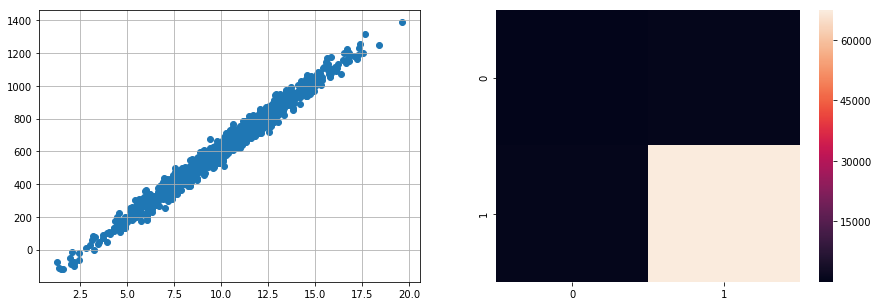

[ 10.09472159 617.60273965]
[  3.05811606 259.53978571]


In [5]:
# sample data to test out the layers
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=1, noise=12.,random_state =9) 
y = y + 200
sample_data = 3*np.hstack((X,np.expand_dims(y,1))) + 10

plt.close('all')
f = plt.figure(figsize=(15, 5))
f.add_subplot(1,2, 1)
plt.grid()
plt.scatter(sample_data[:,0],sample_data[:,1])
f.add_subplot(1,2, 2)
sns.heatmap(np.cov(sample_data.T))
plt.show(block=True)
print(sample_data.mean(axis=0))
print(sample_data.std(axis=0))

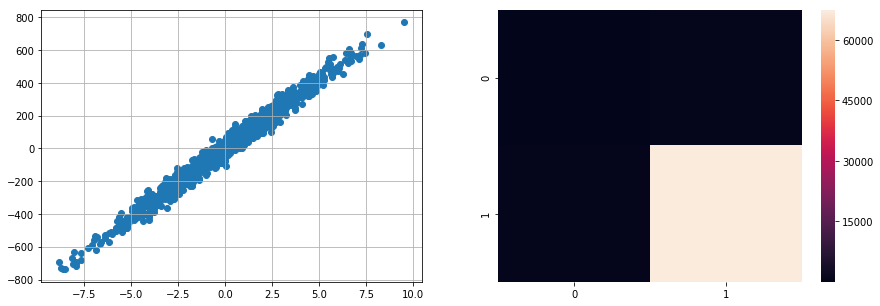

[ 7.57616192e-15 -3.47426976e-13]
[  3.05811606 259.53978571]


In [6]:
plt.close('all')
center_temp = centering_layer(sample_data.shape[0])
centered_data = center_temp.feedforward(sample_data)
f = plt.figure(figsize=(15, 5))
f.add_subplot(1,2, 1)
plt.grid()
plt.scatter(centered_data[:,0],centered_data[:,1])
f.add_subplot(1,2, 2)
sns.heatmap(np.cov(centered_data.T))
plt.show(block=True)
print(centered_data.mean(axis=0))
print(centered_data.std(axis=0))

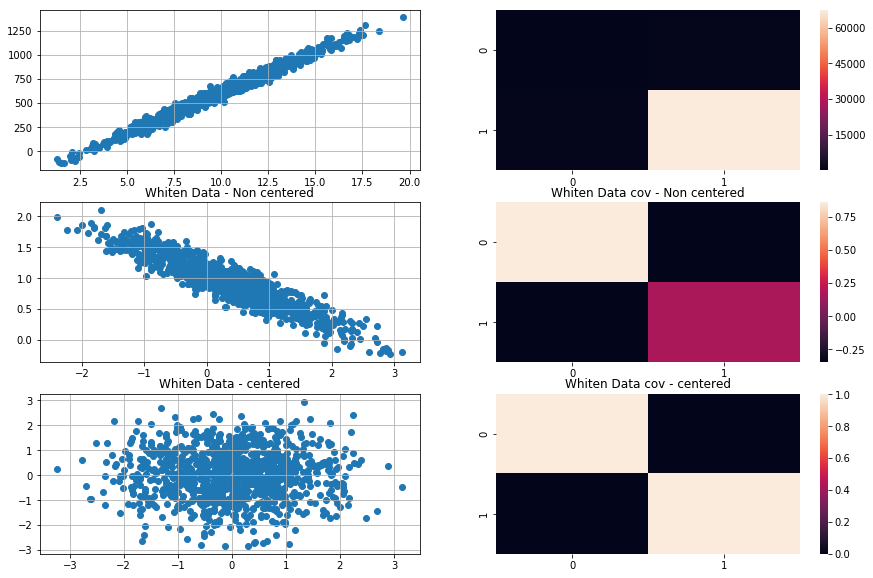

[0.37617904 0.91614233] [0.92654699 0.40085312]
[ 2.73205902e-14 -1.68431935e-15] [1. 1.]


In [9]:
plt.close('all')
whiten_temp = zca_whiten_layer(sample_data.shape[0],sample_data.shape[1])
whiten_data = whiten_temp.feedforward(sample_data)
testing = whiten_temp.backprop(whiten_data)
whiten_data_cen = whiten_temp.feedforward(centered_data)

f = plt.figure(figsize=(15, 10))

f.add_subplot(3,2, 1)
plt.grid()
plt.scatter(sample_data[:,0],sample_data[:,1])
f.add_subplot(3,2, 2)
sns.heatmap(np.cov(sample_data.T))

f.add_subplot(3,2, 3)
plt.title('Whiten Data - Non centered')
plt.grid()
plt.scatter(whiten_data[:,0],whiten_data[:,1])
f.add_subplot(3,2, 4)
plt.title('Whiten Data cov - Non centered')
sns.heatmap(np.cov(whiten_data.T))

f.add_subplot(3,2, 5)
plt.title('Whiten Data - centered')
plt.grid()
plt.scatter(whiten_data_cen[:,0],whiten_data_cen[:,1])
f.add_subplot(3,2, 6)
plt.title('Whiten Data cov - centered')
sns.heatmap(np.cov(whiten_data_cen.T))

plt.show(block=True)
print(whiten_data.mean(axis=0),whiten_data.std(axis=0))
print(whiten_data_cen.mean(axis=0),whiten_data_cen.std(axis=0))

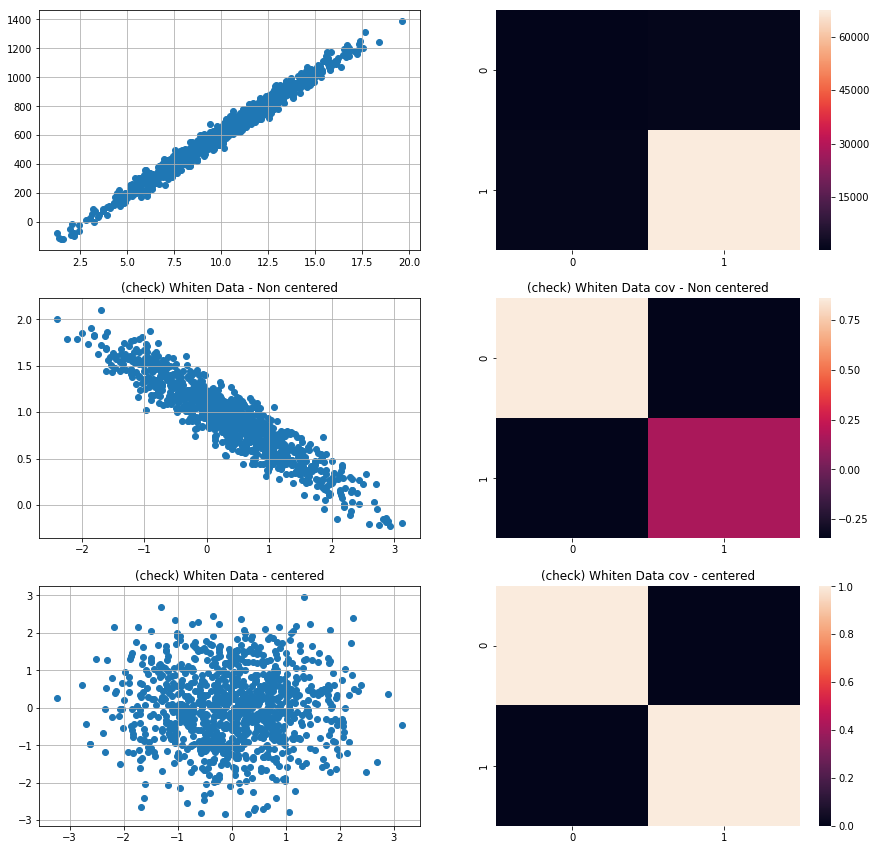

[0.37617904 0.91614233] [0.92654699 0.40085312]
[ 2.73125966e-14 -1.66955338e-15] [1. 1.]


In [10]:
plt.close('all')
whiten_data_check = zca_whiten(sample_data)
whiten_data_check_cen = zca_whiten(centered_data)
f = plt.figure(figsize=(15, 15))

f.add_subplot(3,2, 1)
plt.grid()
plt.scatter(sample_data[:,0],sample_data[:,1])
f.add_subplot(3,2, 2)
sns.heatmap(np.cov(sample_data.T))

f.add_subplot(3,2, 3)
plt.title('(check) Whiten Data - Non centered')
plt.grid()
plt.scatter(whiten_data_check[:,0],whiten_data_check[:,1])
f.add_subplot(3,2, 4)
plt.title('(check) Whiten Data cov - Non centered')
sns.heatmap(np.cov(whiten_data_check.T))

f.add_subplot(3,2, 5)
plt.title('(check) Whiten Data - centered')
plt.grid()
plt.scatter(whiten_data_check_cen[:,0],whiten_data_check_cen[:,1])
f.add_subplot(3,2, 6)
plt.title('(check) Whiten Data cov - centered')
sns.heatmap(np.cov(whiten_data_check_cen.T))

plt.show(block=True)
print(whiten_data_check.mean(axis=0),whiten_data_check.std(axis=0))
print(whiten_data_check_cen.mean(axis=0),whiten_data_check_cen.std(axis=0))

In [9]:
plt.close('all')
decor_batch_norm = Decorrelated_Batch_Norm(sample_data.shape[0],sample_data.shape[1])
decor_batch_norm_data = decor_batch_norm.feedforward(sample_data)
test = decor_batch_norm.backprop(decor_batch_norm_data)
# decor_batch_norm_data_cen = decor_batch_norm.feedforward(centered_data)

# f = plt.figure(figsize=(15, 15))

# f.add_subplot(2,2, 1)
# plt.title('Decorrelated_Batch_Norm - Non centered')
# plt.grid()
# plt.scatter(decor_batch_norm_data[:,0],decor_batch_norm_data[:,1])
# f.add_subplot(2,2, 2)
# plt.title('Decorrelated_Batch_Norm cov - Non centered')
# sns.heatmap(np.cov(decor_batch_norm_data.T))

# f.add_subplot(2,2, 3)
# plt.title('Decorrelated_Batch_Norm - centered')
# plt.grid()
# plt.scatter(decor_batch_norm_data_cen[:,0],decor_batch_norm_data_cen[:,1])
# f.add_subplot(2,2, 4)
# plt.title('Decorrelated_Batch_Norm cov - centered')
# sns.heatmap(np.cov(decor_batch_norm_data_cen.T))

# plt.show(block=True)
print(decor_batch_norm_data.mean(axis=0),decor_batch_norm_data.std(axis=0))
# print(decor_batch_norm_data_cen.mean(axis=0),decor_batch_norm_data_cen.std(axis=0))

[ 2.73185918e-14 -1.67943437e-15] [1. 1.]


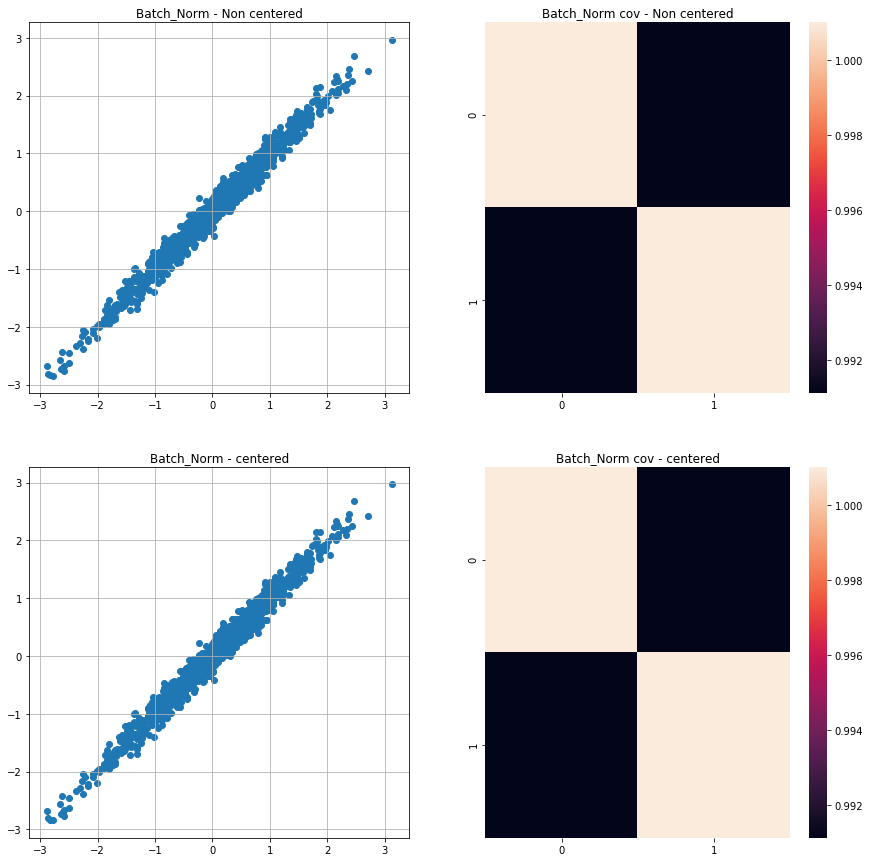

[ 2.47435405e-15 -1.36018974e-15] [1. 1.]
[-3.27515792e-17 -5.01265696e-17] [1. 1.]


In [10]:
plt.close('all')
batch_norm = Batch_Normalization_layer(sample_data.shape[0],sample_data.shape[1])
batch_norm_data = batch_norm.feedforward(sample_data)
batch_norm_data_cen = batch_norm.feedforward(centered_data)
f = plt.figure(figsize=(15, 15))

f.add_subplot(2,2, 1)
plt.title('Batch_Norm - Non centered')
plt.grid()
plt.scatter(batch_norm_data[:,0],batch_norm_data[:,1])
f.add_subplot(2,2, 2)
plt.title('Batch_Norm cov - Non centered')
sns.heatmap(np.cov(batch_norm_data.T))

f.add_subplot(2,2, 3)
plt.title('Batch_Norm - centered')
plt.grid()
plt.scatter(batch_norm_data_cen[:,0],batch_norm_data_cen[:,1])
f.add_subplot(2,2, 4)
plt.title('Batch_Norm cov - centered')
sns.heatmap(np.cov(batch_norm_data_cen.T))

plt.show(block=True)
print(batch_norm_data.mean(axis=0),batch_norm_data.std(axis=0))
print(batch_norm_data_cen.mean(axis=0),batch_norm_data_cen.std(axis=0))

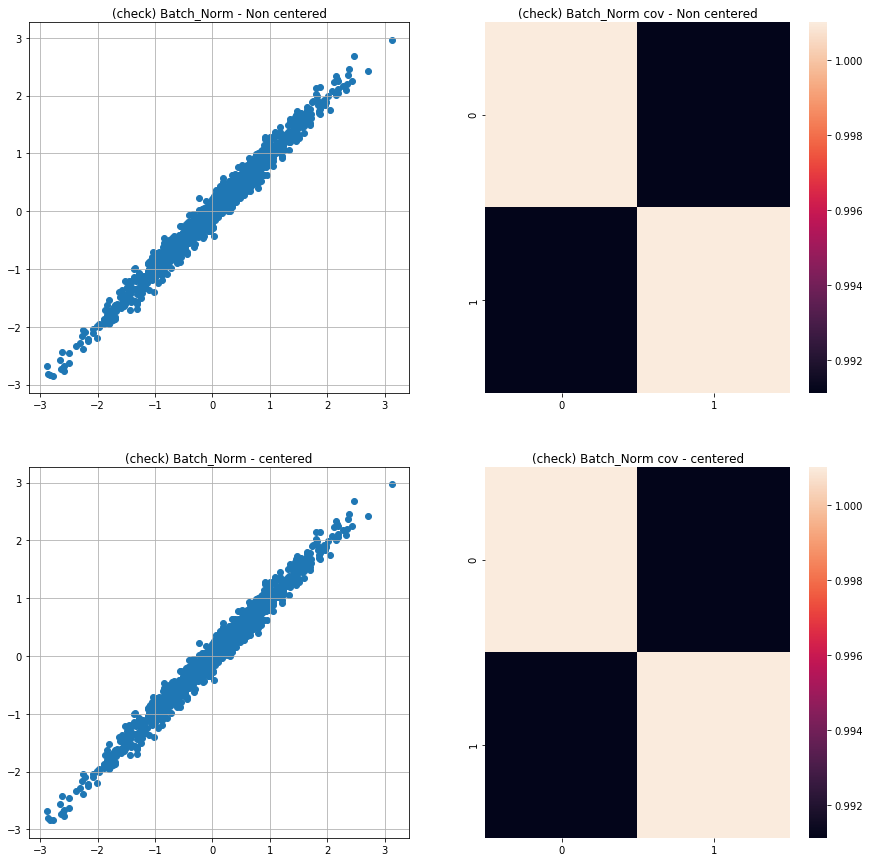

[ 2.47790677e-15 -9.18320975e-16] [1. 1.]
[-2.57571742e-17 -4.67959005e-17] [1. 1.]


In [11]:
plt.close('all')
batch_norm_data_check = batchnorm_forward(sample_data)
batch_norm_data_cen_check = batchnorm_forward(centered_data)
f = plt.figure(figsize=(15, 15))

f.add_subplot(2,2, 1)
plt.title('(check) Batch_Norm - Non centered')
plt.grid()
plt.scatter(batch_norm_data_check[:,0],batch_norm_data_check[:,1])
f.add_subplot(2,2, 2)
plt.title('(check) Batch_Norm cov - Non centered')
sns.heatmap(np.cov(batch_norm_data_check.T))

f.add_subplot(2,2, 3)
plt.title('(check) Batch_Norm - centered')
plt.grid()
plt.scatter(batch_norm_data_cen_check[:,0],batch_norm_data_cen_check[:,1])
f.add_subplot(2,2, 4)
plt.title('(check) Batch_Norm cov - centered')
sns.heatmap(np.cov(batch_norm_data_cen_check.T))

plt.show(block=True)
print(batch_norm_data_check.mean(axis=0),batch_norm_data_check.std(axis=0))
print(batch_norm_data_cen_check.mean(axis=0),batch_norm_data_cen_check.std(axis=0))

In [12]:
# back propagation test 
batch_norm_grad = Batch_Normalization_layer(sample_data.shape[0],sample_data.shape[1])
test_batch_out   = batch_norm_grad.feedforward(sample_data)
test_batch_grad  = batch_norm_grad.backprop(test_batch_out)

print(test_batch_out.shape)
print(np.abs(test_batch_out).sum())
print(np.abs(test_batch_out).mean())

print(test_batch_grad.shape)
print(np.abs(test_batch_grad).sum())
print(np.abs(test_batch_grad).mean())

(1000, 2)
1604.1044287813083
0.8020522143906542
(1000, 2)
2.8069210566866977e-09
1.4034605283433488e-12


In [13]:
def batchnorm_forward(x):
    N, D = x.shape
    gamma = 1.0;beta = 0.0;eps=1e-10

    #step1: calculate mean
    mu = 1./N * np.sum(x, axis = 0)

    #step2: subtract mean vector of every trainings example
    xmu = x - mu

    #step3: following the lower branch - calculation denominator
    sq = xmu ** 2

    #step4: calculate variance
    var = 1./N * np.sum(sq, axis = 0)

    #step5: add eps for numerical stability, then sqrt
    sqrtvar = np.sqrt(var + eps)

    #step6: invert sqrtwar
    ivar = 1./sqrtvar

    #step7: execute normalization
    xhat = xmu * ivar

    #step8: Nor the two transformation steps
    gammax = gamma * xhat

    #step9
    out = gammax + beta

    #store intermediate
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)

    return out, cache

def batchnorm_backward(dout, cache):
    #unfold the variables stored in cache
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache

    #get the dimensions of the input/output
    N,D = dout.shape

    #step9
    dbeta = np.sum(dout, axis=0)
    dgammax = dout #not necessary, but more understandable

    #step8
    dgamma = np.sum(dgammax*xhat, axis=0)
    dxhat = dgammax * gamma

    #step7
    divar = np.sum(dxhat*xmu, axis=0)
    dxmu1 = dxhat * ivar

    #step6
    dsqrtvar = -1. /(sqrtvar**2) * divar

    #step5
    dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

    #step4
    dsq = 1. /N * np.ones((N,D)) * dvar

    #step3
    dxmu2 = 2 * xmu * dsq

    #step2
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

    #step1
    dx2 = 1. /N * np.ones((N,D)) * dmu

    #step0
    dx = dx1 + dx2

    return dx

In [14]:
test_batch_out_check,check_cache   = batchnorm_forward(sample_data)
test_batch_grad_check  = batchnorm_backward(test_batch_out_check,check_cache)

print(test_batch_out_check.shape)
print(np.abs(test_batch_out_check).sum())
print(np.abs(test_batch_out_check).mean())

print(test_batch_grad_check.shape)
print(np.abs(test_batch_grad_check).sum())
print(np.abs(test_batch_grad_check).mean())

(1000, 2)
1604.1044287813083
0.8020522143906542
(1000, 2)
2.8065458864205125e-09
1.4032729432102562e-12


In [15]:
sample_data.shape

(1000, 2)

In [16]:
mu = np.mean(sample_data,0)
mu.shape

(2,)

(1000, 2)
[ 7.57616192e-15 -2.43517206e-13]
[[9.35207385e+00 7.85877499e+02]
 [7.85877499e+02 6.73609004e+04]]


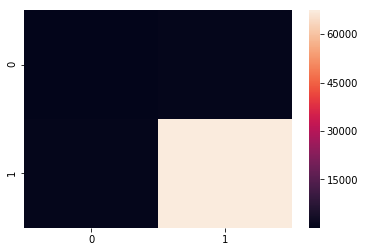

In [17]:
mean_data = sample_data - mu
min_co =  mean_data.T.dot(mean_data) / 1000
print(mean_data.shape)
print(mean_data.mean(0))
print(min_co)
sns.heatmap(min_co)

(2, 1)
(2, 1)
(2, 1)
[-1.17970522e-10]
[[ 5.73982294e-26 -1.84492579e-24]
 [-1.84492579e-24  5.93006298e-23]]


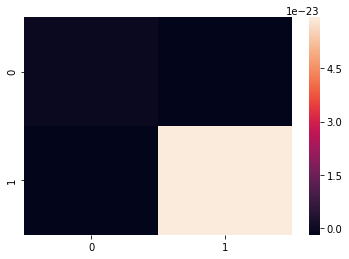

In [18]:
one = np.expand_dims(np.sum(sample_data - mu,0),1)
two = np.expand_dims(np.sum(sample_data - mu,0),1)
print(one.shape)
print(two.shape)
three = one.dot(two.T) / 1000
print(one.shape)
print(one.mean(0))
print(three)
sns.heatmap(three)

In [19]:
import numpy as np
def my_covar(X):  
    mu = np.sum(X,axis=0) / X.shape[0]
    X_mean = X - mu 
    return X_mean.T.dot(X_mean) / X.shape[0]
#     N = X.shape[1]  
#     return np.dot(X, X.T.conj())/float(N-1)

X = np.asarray([[1.0,1.0],[2.0,2.0],[3.0,3.0]])
print(X)
print(my_covar(X.T))
print('-----')
print(np.cov(X))

[[1. 1.]
 [2. 2.]
 [3. 3.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-----
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
